In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, concatenate, SimpleRNN, GRU, Masking, Lambda, Reshape, Dropout, RNN
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython.display import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns

Welcome to JupyROOT 6.19/01


In [2]:
def min_max_renormal(numpy_array):
    mydf=pd.DataFrame(data=numpy_array)
    normalize_df=(mydf-mydf.min())/(mydf.max()-mydf.min())
    normalize_np=normalize_df.values
    print(normalize_np)
    return(normalize_np)

Load signal and background trees

In [3]:
signalFile=TFile.Open("../sample-0702/sig_bbtautau.root")
backgroundFile=TFile.Open("../sample-0702/bkg_DY_ttbar.root")

In [4]:
signalTree=signalFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [5]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  218391
background events number before cut is:  15829706


Convert minitree into numpy

In [6]:
signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
print(signalArray.shape)

(218391, 24)


In [7]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  4.113375714827224
background yield before cut is: 2061867.8801074543


In [8]:
dataSignal=pd.DataFrame(data=signalArray[:,3:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

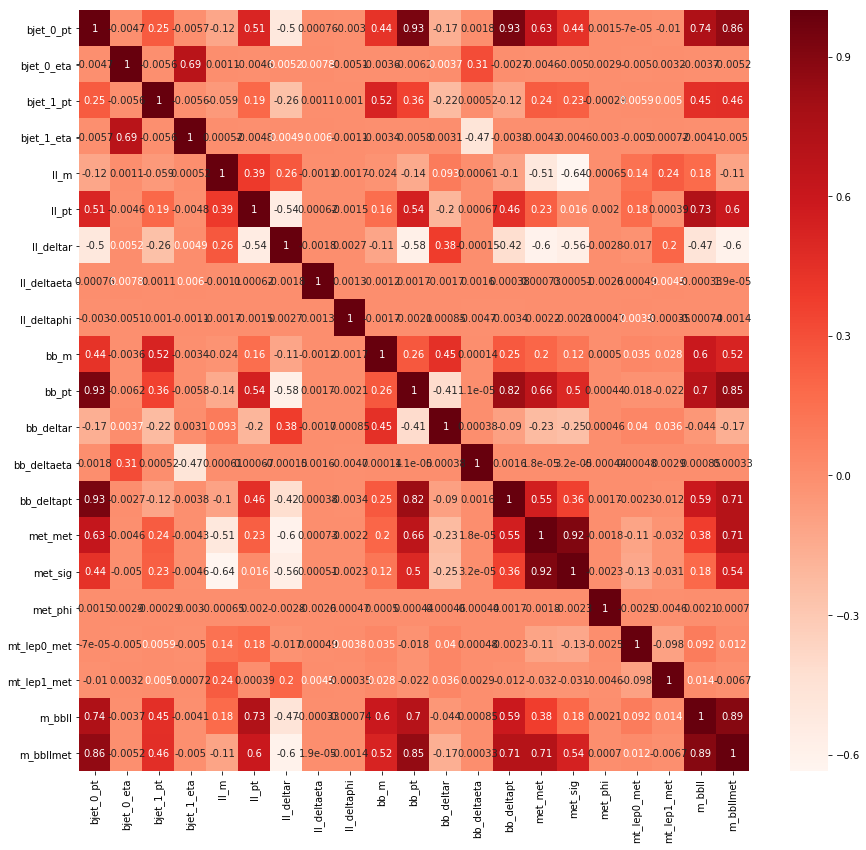

In [ ]:
plt.figure(figsize=(15,14))
cor = dataSignal.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
dataBackground=pd.DataFrame(data=backgroundArray[:,3:],columns=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
plt.figure(figsize=(16,16))
cor = dataBackground.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()



In [ ]:
print(signalArray)

In [ ]:
print(signalArray[:,1])

Add signal Region cuts $m_{jj}>300$ Gev and $|\Delta(y_{jj})|>2.0$.

In [ ]:
signalSample=signalArray[(abs(signalArray[:,7])>75000.0)&((signalArray[:,1]==1)|(signalArray[:,2]==1))]
backgroundSample=backgroundArray[(abs(backgroundArray[:,7])>75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]

In [ ]:
print(len(signalSample))
print(len(backgroundSample))

In [ ]:
signalNum=len(signalSample)
backgroundNum=len(backgroundSample)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample[:,0]))
print("background yield after cut is:",sum(backgroundSample[:,0]))

Split datasets into training and testing subsets

In [ ]:
trainingRatio=0.9
sigTrainNum=int(signalNum*0.9)
backgroundTrainNum=int(backgroundNum*0.9)
sigTestNum=signalNum-sigTrainNum
backgroundTestNum=backgroundNum-backgroundTrainNum
print("training signal events number is: ",sigTrainNum)
print("testing signal events number is: ",sigTestNum)
print("training background events number is: ",backgroundTrainNum)
print("testing background events number is: ",backgroundTestNum)


In [ ]:
signal_row=np.arange(0,signalNum-1,1)
background_row=np.arange(0,backgroundNum-1,1)
signal_train_row=np.random.choice(signal_row,size=sigTrainNum,replace=False)
background_train_row=np.random.choice(background_row,size=backgroundTrainNum,replace=False)
label_signal_train=np.ones((sigTrainNum,1))
label_background_train=np.zeros((backgroundTrainNum,1))
label_signal_test=np.ones((sigTestNum,1))
label_background_test=np.zeros((backgroundTestNum,1))
signalTrain=signalSample[signal_train_row,:]
signalTest=np.delete(signalSample,signal_train_row,axis=0)
backgroundTrain=backgroundSample[background_train_row,:]
backgroundTest=np.delete(backgroundSample,background_train_row,axis=0)
signalTrain=np.concatenate((label_signal_train,signalTrain),axis=1)
backgroundTrain=np.concatenate((label_background_train,backgroundTrain),axis=1)
signalTest=np.concatenate((label_signal_test,signalTest),axis=1)
backgroundTest=np.concatenate((label_background_test,backgroundTest),axis=1)
ratio=sum(signalTrain[:,1])/sum(backgroundTrain[:,1])
signalTrain[:,1]=signalTrain[:,1]/ratio
print(backgroundTest)
print(ratio)

In [ ]:
dataTrain=np.vstack((signalTrain,backgroundTrain))
dataTest=np.vstack((signalTest,backgroundTest))
np.random.shuffle(dataTrain)
np.random.shuffle(dataTest)
dataTrainLabel=dataTrain[:,0]
dataTrainWeight=dataTrain[:,1]
dataTrainSample=dataTrain[:,4:]
dataTestLabel=dataTest[:,0]
dataTestWeight=dataTest[:,1]
dataTestSample=dataTest[:,4:]
tf.cast(dataTrainLabel,tf.float32)
tf.cast(dataTrainSample,tf.float32)

Signal and background training sets should have same yield in training

In [ ]:
plt.hist(dataTrain[:,0],weights=dataTrainWeight)
print(dataTrainWeight.shape)
dataTrainWeight=dataTrainWeight.transpose()
print(dataTrainWeight.shape)
classweight = {0: 19.75,
                1: 1.}

Build model

In [ ]:
dataTrainSample1=min_max_renormal(dataTrainSample)

In [ ]:
model = Sequential()
model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
    input_dim=21))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

# Set loss, optimizer and evaluation metrics
model.compile(
     loss="binary_crossentropy",
     #optimizer=Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
      optimizer='adam',
     metrics=["acc"])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='acc',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [ ]:
model.save('model_HHtt.h5')
model.summary()

In [ ]:
model.fit(dataTrainSample1,dataTrainLabel,batch_size=50, epochs=30,
          sample_weight=dataTrainWeight,
          callbacks=[early_stopping])

In [ ]:
signalSample1=min_max_renormal(signalSample[:,1:])
backgroundSample1=min_max_renormal(backgroundSample[:,1:])

In [ ]:
signalNN=model.predict(signalSample1)
backgroundNN=model.predict(backgroundSample1)
plt.hist(signalNN,bins=20)
plt.hist(backgroundNN,bins=20)
NNTrainScore=model.predict(dataTrainSample1)

In [ ]:
backgroundNN=model.predict(backgroundSample1)
plt.hist(backgroundNN,bins=20)

Save NN model to h5 file

In [ ]:
model.save('model_4lHHtt.h5')
model.summary()

In [ ]:
signalNNScore=model.predict(signalSample1)
#backgroundNNScore=model.predict(backgroundArray[:,1:])
print(signalNNScore)

In [ ]:
plt.hist(signalNNScore,bins=20)

In [ ]:
def baseline_model():
    model = Sequential()
    model.add(Dense(300, kernel_initializer="glorot_normal", activation="relu",
         input_dim=21))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(300, kernel_initializer="random_normal", activation="relu"))
    model.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))
    model.compile(
     loss="binary_crossentropy",
     optimizer="adam",
     metrics=["accuracy"])
    return model

In [ ]:
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=9, batch_size=50, verbose=False)
estimator.fit(dataTrainSample1,dataTrainLabel,sample_weight=dataTrainWeight)
perm = PermutationImportance(estimator, random_state=1).fit(dataTrainSample1,dataTrainLabel)

In [ ]:
eli5.show_weights(perm,feature_names=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [ ]:
cuda.select_device(0)
cuda.close()

In [ ]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTtrain=xgb.DMatrix(dataTrainSample,label=dataTrainLabel,weight=dataTrainWeight,feature_names=varName)
BDTtest=xgb.DMatrix(dataTestSample,label=dataTestLabel,weight=dataTestWeight,feature_names=varName)
BDTSignal=xgb.DMatrix(signalSample[:,3:],feature_names=varName)
BDTBackground=xgb.DMatrix(backgroundSample[:,3:],feature_names=varName)
param = {'max_depth': 7, 'eta': 0.6, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 16
param['eval_metric'] = 'auc'
param['tree_method'] = 'gpu_hist'
param['grow_policy'] = 'depthwise'
param['subsample']=0.9
evallist = [(BDTtest, 'eval'), (BDTtrain, 'train')]

In [ ]:
num_round = 1000
GBDT = xgb.train(param, BDTtrain, num_round, evallist,early_stopping_rounds=10)

In [ ]:
xgb.plot_importance(GBDT,importance_type="gain")

In [ ]:
SignalScore=GBDT.predict(BDTSignal)
#plt.hist(SignalScore,bins=20)
BackgroundScore=GBDT.predict(BDTBackground)
plt.hist(BackgroundScore,bins=20,weights=backgroundSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

In [ ]:
plt.hist(SignalScore,bins=20,weights=signalSample[:,0])
plt.ylabel('Events/0.05')
plt.xlabel('BDT Score')
plt.show()

In [ ]:
plot_tree(GBDT, num_trees=4)

In [ ]:
trainScore=GBDT.predict(BDTtrain)
testScore=GBDT.predict(BDTtest)
plt.hist(trainScore,bins=20)

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,trainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTrainLabel,NNTrainScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
pickle.dump(GBDT, open("../BDT_model/GBDT_HHtt_low.pickle.dat", "wb"))

In [ ]:
fpr, tpr, threshold=sklearn.metrics.roc_curve(dataTestLabel,testScore)
roc_auc = sklearn.metrics.auc(fpr, tpr)

In [ ]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
sumw=0
for (score,weight) in zip(SignalScore,signalSample[:,0]):
    if(score>0.975):
        sumw=sumw+weight
print(sumw)

In [ ]:
sumw=0
for (score,weight) in zip(BackgroundScore,backgroundSample[:,0]):
    if(score>0.975):
        sumw=sumw+weight
print(sumw)